<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Meta/blob/master/tutorials/1-Introduction/FinRL_PortfolioAllocation_NeurIPS_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Portfolio Allocation

Tutorials to use OpenAI DRL to perform portfolio allocation in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: https://towardsdatascience.com/finrl-for-quantitative-finance-tutorial-for-portfolio-allocation-9b417660c7cd
* Please report any issues to our Github: https://github.com/AI4Finance-Foundation/FinRL/issues

ESG-VARIABLES-PENALIZING
* **Pytorch Version**

# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for portfolio alloacation. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A represents the weight of a stock in the porfolio: a ∈ (-1,1). Assume our stock pool includes N stocks, we can use a list [a<sub>1</sub>, a<sub>2</sub>, ... , a<sub>N</sub>] to determine the weight for each stock in the porfotlio, where a<sub>i</sub> ∈ (-1,1), a<sub>1</sub>+ a<sub>2</sub>+...+a<sub>N</sub>=1. For example, "The weight of AAPL in the portfolio is 10%." is [0.1 , ...].

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library



<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them.
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
!pip install stockstats
!pip install hyperopt
!pip install pyfolio
import stockstats
from hyperopt import fmin, tpe, hp, Trials, space_eval
import pyfolio
from collections import deque

/usr/local/lib/python3.11/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


<a id='1.4'></a>
## 2.4. FinRL Offline Scripts

<a id='1.4'></a>
## 2.4.1. Yahoo Downloader (from finrl.meta.preprocessor.yahoodownloader import YahooDownloader)

In [2]:
"""Contains methods and classes to collect data from
Yahoo Finance API
"""

from __future__ import annotations

import pandas as pd
import yfinance as yf


class YahooDownloader:
    """Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from neofinrl_config.py)
        end_date : str
            end date of the data (modified from neofinrl_config.py)
        ticker_list : list
            a list of stock tickers (modified from neofinrl_config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API

    """

    def __init__(self, start_date: str, end_date: str, ticker_list: list):
        self.start_date = start_date
        self.end_date = end_date
        self.ticker_list = ticker_list

    def fetch_data(self, proxy=None, auto_adjust=False) -> pd.DataFrame:
        """Fetches data from Yahoo API
        Parameters
        ----------

        Returns
        -------
        `pd.DataFrame`
            7 columns: A date, open, high, low, close, volume and tick symbol
            for the specified stock ticker
        """
        # Download and save the data in a pandas DataFrame:
        data_df = pd.DataFrame()
        num_failures = 0
        for tic in self.ticker_list:
            temp_df = yf.download(
                tic,
                start=self.start_date,
                end=self.end_date,
                proxy=proxy,
                auto_adjust=auto_adjust,
            )
            if temp_df.columns.nlevels != 1:
                temp_df.columns = temp_df.columns.droplevel(1)
            temp_df["tic"] = tic
            if len(temp_df) > 0:
                # data_df = data_df.append(temp_df)
                data_df = pd.concat([data_df, temp_df], axis=0)
            else:
                num_failures += 1
        if num_failures == len(self.ticker_list):
            raise ValueError("no data is fetched.")
        # reset the index, we want to use numbers as index instead of dates
        data_df = data_df.reset_index()
        try:
            # convert the column names to standardized names
            data_df.rename(
                columns={
                    "Date": "date",
                    "Adj Close": "adjcp",
                    "Close": "close",
                    "High": "high",
                    "Low": "low",
                    "Volume": "volume",
                    "Open": "open",
                    "tic": "tic",
                },
                inplace=True,
            )

            # use adjusted close price instead of close price
            data_df["close"] = data_df["adjcp"]
            # drop the adjusted close price column
            data_df = data_df.drop(labels="adjcp", axis=1)
        except NotImplementedError:
            print("the features are not supported currently")
        # create day of the week column (monday = 0)
        data_df["day"] = data_df["date"].dt.dayofweek
        # convert date to standard string format, easy to filter
        data_df["date"] = data_df.date.apply(lambda x: x.strftime("%Y-%m-%d"))
        # drop missing data
        data_df = data_df.dropna()
        data_df = data_df.reset_index(drop=True)
        print("Shape of DataFrame: ", data_df.shape)
        # print("Display DataFrame: ", data_df.head())

        data_df = data_df.sort_values(by=["date", "tic"]).reset_index(drop=True)

        return data_df

    def select_equal_rows_stock(self, df):
        df_check = df.tic.value_counts()
        df_check = pd.DataFrame(df_check).reset_index()
        df_check.columns = ["tic", "counts"]
        mean_df = df_check.counts.mean()
        equal_list = list(df.tic.value_counts() >= mean_df)
        names = df.tic.value_counts().index
        select_stocks_list = list(names[equal_list])
        df = df[df.tic.isin(select_stocks_list)]
        return df

<a id='1.4'></a>
## 2.4.2. Data Split (from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split)

In [3]:
import datetime
import numpy as np
import pandas as pd
from multiprocessing.sharedctypes import Value

import numpy as np
import pandas as pd
from stockstats import StockDataFrame as Sdf

def load_dataset(*, file_name: str) -> pd.DataFrame:
    """
    load csv dataset from path
    :return: (df) pandas dataframe
    """
    # _data = pd.read_csv(f"{config.DATASET_DIR}/{file_name}")
    _data = pd.read_csv(file_name)
    return _data


def data_split(df, start, end, target_date_col="date"):
    """
    split the dataset into training or testing using date
    :param data: (df) pandas dataframe, start, end
    :return: (df) pandas dataframe
    """
    data = df[(df[target_date_col] >= start) & (df[target_date_col] < end)]
    data = data.sort_values([target_date_col, "tic"], ignore_index=True)
    data.index = data[target_date_col].factorize()[0]
    return data


def convert_to_datetime(time):
    time_fmt = "%Y-%m-%dT%H:%M:%S"
    if isinstance(time, str):
        return datetime.datetime.strptime(time, time_fmt)

<a id='1.4'></a>
## 2.4.3. Backtesting Functions (from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts)

In [4]:
from __future__ import annotations

import copy
import datetime
from copy import deepcopy
import empyrical as ep

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyfolio
from pyfolio import timeseries
import itertools

# Replacing from pyfolio import timeseries with original codes ##

def gross_lev(positions):
    """
    Calculates the gross leverage of a strategy.

    Parameters
    ----------
    positions : pd.DataFrame
        Daily net position values.
         - See full explanation in tears.create_full_tear_sheet.

    Returns
    -------
    pd.Series
        Gross leverage.
    """

    exposure = positions.drop('cash', axis=1).abs().sum(axis=1)
    return exposure / positions.sum(axis=1)

def get_txn_vol(transactions):
    """
    Extract daily transaction data from set of transaction objects.

    Parameters
    ----------
    transactions : pd.DataFrame
        Time series containing one row per symbol (and potentially
        duplicate datetime indices) and columns for amount and
        price.

    Returns
    -------
    pd.DataFrame
        Daily transaction volume and number of shares.
         - See full explanation in tears.create_full_tear_sheet.
    """

    txn_norm = transactions.copy()
    txn_norm.index = txn_norm.index.normalize()
    amounts = txn_norm.amount.abs()
    prices = txn_norm.price
    values = amounts * prices
    daily_amounts = amounts.groupby(amounts.index).sum()
    daily_values = values.groupby(values.index).sum()
    daily_amounts.name = "txn_shares"
    daily_values.name = "txn_volume"
    return pd.concat([daily_values, daily_amounts], axis=1)

def get_turnover(positions, transactions, denominator='AGB'):
    """
     - Value of purchases and sales divided
    by either the actual gross book or the portfolio value
    for the time step.

    Parameters
    ----------
    positions : pd.DataFrame
        Contains daily position values including cash.
        - See full explanation in tears.create_full_tear_sheet
    transactions : pd.DataFrame
        Prices and amounts of executed trades. One row per trade.
        - See full explanation in tears.create_full_tear_sheet
    denominator : str, optional
        Either 'AGB' or 'portfolio_value', default AGB.
        - AGB (Actual gross book) is the gross market
        value (GMV) of the specific algo being analyzed.
        Swapping out an entire portfolio of stocks for
        another will yield 200% turnover, not 100%, since
        transactions are being made for both sides.
        - We use average of the previous and the current end-of-period
        AGB to avoid singularities when trading only into or
        out of an entire book in one trading period.
        - portfolio_value is the total value of the algo's
        positions end-of-period, including cash.

    Returns
    -------
    turnover_rate : pd.Series
        timeseries of portfolio turnover rates.
    """

    txn_vol = get_txn_vol(transactions)
    traded_value = txn_vol.txn_volume

    if denominator == 'AGB':
        # Actual gross book is the same thing as the algo's GMV
        # We want our denom to be avg(AGB previous, AGB current)
        AGB = positions.drop('cash', axis=1).abs().sum(axis=1)
        denom = AGB.rolling(2).mean()

        # Since the first value of pd.rolling returns NaN, we
        # set our "day 0" AGB to 0.
        denom.iloc[0] = AGB.iloc[0] / 2
    elif denominator == 'portfolio_value':
        denom = positions.sum(axis=1)
    else:
        raise ValueError(
            "Unexpected value for denominator '{}'. The "
            "denominator parameter must be either 'AGB'"
            " or 'portfolio_value'.".format(denominator)
        )

    denom.index = denom.index.normalize()
    turnover = traded_value.div(denom, axis='index')
    turnover = turnover.fillna(0)
    return turnover

SIMPLE_STAT_FUNCS = [
    ep.annual_return,
    ep.cum_returns_final,
    ep.annual_volatility,
    ep.sharpe_ratio,
    ep.calmar_ratio,
    ep.stability_of_timeseries,
    # ep.max_drawdown,
    ep.omega_ratio,
    # ep.sortino_ratio,
    # stats.skew,
    # stats.kurtosis,
    # ep.tail_ratio,
    # value_at_risk
]

FACTOR_STAT_FUNCS = [
    # ep.alpha,
    # ep.beta,
]

STAT_FUNC_NAMES = {
    'annual_return': 'Annual return',
    'cum_returns_final': 'Cumulative returns',
    'annual_volatility': 'Annual volatility',
    'sharpe_ratio': 'Sharpe ratio',
    'calmar_ratio': 'Calmar ratio',
    'stability_of_timeseries': 'Stability',
    # 'max_drawdown': 'Max drawdown',
    'omega_ratio': 'Omega ratio',
    # 'sortino_ratio': 'Sortino ratio',
    # 'skew': 'Skew',
    # 'kurtosis': 'Kurtosis',
    # 'tail_ratio': 'Tail ratio',
    # 'common_sense_ratio': 'Common sense ratio',
    # 'value_at_risk': 'Daily value at risk',
    # 'alpha': 'Alpha',
    # 'beta': 'Beta',
}


def perf_stats(returns, factor_returns=None, positions=None,
               transactions=None, turnover_denom='AGB'):
    """
    Calculates various performance metrics of a strategy, for use in
    plotting.show_perf_stats.

    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    factor_returns : pd.Series, optional
        Daily noncumulative returns of the benchmark factor to which betas are
        computed. Usually a benchmark such as market returns.
         - This is in the same style as returns.
         - If None, do not compute alpha, beta, and information ratio.
    positions : pd.DataFrame
        Daily net position values.
         - See full explanation in tears.create_full_tear_sheet.
    transactions : pd.DataFrame
        Prices and amounts of executed trades. One row per trade.
        - See full explanation in tears.create_full_tear_sheet.
    turnover_denom : str
        Either AGB or portfolio_value, default AGB.
        - See full explanation in txn.get_turnover.

    Returns
    -------
    pd.Series
        Performance metrics.
    """

    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns)

    if positions is not None:
        stats['Gross leverage'] = gross_lev(positions).mean()
        if transactions is not None:
            stats['Daily turnover'] = get_turnover(positions,
                                                   transactions,
                                                   turnover_denom).mean()
    if factor_returns is not None:
        for stat_func in FACTOR_STAT_FUNCS:
            res = stat_func(returns, factor_returns)
            stats[STAT_FUNC_NAMES[stat_func.__name__]] = res

    return stats
#######################
def date2str(dat: datetime.date) -> str:
    return datetime.date.strftime(dat, "%Y-%m-%d")

def str2date(dat: str) -> datetime.date:
    return datetime.datetime.strptime(dat, "%Y-%m-%d").date()

def get_daily_return(df, value_col_name="account_value"):
    df = deepcopy(df)
    df["daily_return"] = df[value_col_name].pct_change(1)
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True, drop=True)
    df.index = df.index.tz_localize("UTC")
    return pd.Series(df["daily_return"], index=df.index)


def convert_daily_return_to_pyfolio_ts(df):
    strategy_ret = df.copy()
    strategy_ret["date"] = pd.to_datetime(strategy_ret["date"])
    strategy_ret.set_index("date", drop=False, inplace=True)
    strategy_ret.index = strategy_ret.index.tz_localize("UTC")
    del strategy_ret["date"]
    return pd.Series(strategy_ret["daily_return"].values, index=strategy_ret.index)


# def backtest_stats(account_value, value_col_name="account_value"):
#     dr_test = get_daily_return(account_value, value_col_name=value_col_name)
#     perf_stats_all = timeseries.perf_stats(
#         returns=dr_test,
#         positions=None,
#         transactions=None,
#         turnover_denom="AGB",
#     )
#     print(perf_stats_all)
#     return perf_stats_all

def backtest_stats(account_value, value_col_name="account_value"):
    dr_test = get_daily_return(account_value, value_col_name=value_col_name)
    perf_stats_all = perf_stats(
        returns=dr_test,
        positions=None,
        transactions=None,
        turnover_denom="AGB",
    )
    print(perf_stats_all)
    return perf_stats_all


# def backtest_plot(
#     account_value,
#     baseline_start=TRADE_START_DATE,
#     baseline_end=TRADE_END_DATE,
#     baseline_ticker="^DJI",
#     value_col_name="account_value",
# ):
#     df = deepcopy(account_value)
#     df["date"] = pd.to_datetime(df["date"])
#     test_returns = get_daily_return(df, value_col_name=value_col_name)

#     baseline_df = get_baseline(
#         ticker=baseline_ticker, start=baseline_start, end=baseline_end
#     )

#     baseline_df["date"] = pd.to_datetime(baseline_df["date"], format="%Y-%m-%d")
#     baseline_df = pd.merge(df[["date"]], baseline_df, how="left", on="date")
#     baseline_df = baseline_df.fillna(method="ffill").fillna(method="bfill")
#     baseline_returns = get_daily_return(baseline_df, value_col_name="close")

#     with pyfolio.plotting.plotting_context(font_scale=1.1):
#         pyfolio.create_full_tear_sheet(
#             returns=test_returns, benchmark_rets=baseline_returns, set_context=False
#         )


def get_baseline(ticker, start, end):
    return YahooDownloader(
        start_date=start, end_date=end, ticker_list=[ticker]
    ).fetch_data()


def trx_plot(df_trade, df_actions, ticker_list):
    df_trx = pd.DataFrame(np.array(df_actions["transactions"].to_list()))
    df_trx.columns = ticker_list
    df_trx.index = df_actions["date"]
    df_trx.index.name = ""

    for i in range(df_trx.shape[1]):
        df_trx_temp = df_trx.iloc[:, i]
        df_trx_temp_sign = np.sign(df_trx_temp)
        buying_signal = df_trx_temp_sign.apply(lambda x: x > 0)
        selling_signal = df_trx_temp_sign.apply(lambda x: x < 0)

        tic_plot = df_trade[
            (df_trade["tic"] == df_trx_temp.name)
            & (df_trade["date"].isin(df_trx.index))
        ]["close"]
        tic_plot.index = df_trx_temp.index

        plt.figure(figsize=(10, 8))
        plt.plot(tic_plot, color="g", lw=2.0)
        plt.plot(
            tic_plot,
            "^",
            markersize=10,
            color="m",
            label="buying signal",
            markevery=buying_signal,
        )
        plt.plot(
            tic_plot,
            "v",
            markersize=10,
            color="k",
            label="selling signal",
            markevery=selling_signal,
        )
        plt.title(
            f"{df_trx_temp.name} Num Transactions: {len(buying_signal[buying_signal == True]) + len(selling_signal[selling_signal == True])}"
        )
        plt.legend()
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=25))
        plt.xticks(rotation=45, ha="right")
        plt.show()


# 2022-01-15 -> 01/15/2022
def transfer_date(str_dat):
    return datetime.datetime.strptime(str_dat, "%Y-%m-%d").date().strftime("%m/%d/%Y")


def plot_result_from_csv(
    csv_file: str,
    column_as_x: str,
    savefig_filename: str = "fig/result.png",
    xlabel: str = "Date",
    ylabel: str = "Result",
    num_days_xticks: int = 20,
    xrotation: int = 0,
):
    result = pd.read_csv(csv_file)
    plot_result(
        result,
        column_as_x,
        savefig_filename,
        xlabel,
        ylabel,
        num_days_xticks,
        xrotation,
    )


# select_start_date: included
# select_end_date: included
# is if_need_calc_return is True, it is account_value, and then transfer it to return
# it is better that column_as_x is the first column, and the other columns are strategies
# xrotation: the rotation of xlabel, may be used in dates. Default=0 (adaptive adjustment)
def plot_result(
    result: pd.DataFrame(),
    column_as_x: str,
    savefig_filename: str = "fig/result.png",
    xlabel: str = "Date",
    ylabel: str = "Result",
    num_days_xticks: int = 20,
    xrotation: int = 0,
):
    columns = result.columns
    columns_strtegy = []
    for i in range(len(columns)):
        col = columns[i]
        if "Unnamed" not in col and col != column_as_x:
            columns_strtegy.append(col)

    result.reindex()

    x = result[column_as_x].values.tolist()
    plt.rcParams["figure.figsize"] = (15, 6)
    # plt.figure()

    fig, ax = plt.subplots()
    colors = [
        "black",
        "red",
        "green",
        "blue",
        "cyan",
        "magenta",
        "yellow",
        "aliceblue",
        "coral",
        "darksalmon",
        "firebrick",
        "honeydew",
    ]
    for i in range(len(columns_strtegy)):
        col = columns_strtegy[i]
        ax.plot(
            x,
            result[col],
            color=colors[i],
            linewidth=1,
            linestyle="-",
        )

    plt.title("", fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)

    plt.legend(labels=columns_strtegy, loc="best", fontsize=16)

    # set grid
    plt.grid()

    plt.xticks(size=22)  # 设置刻度大小
    plt.yticks(size=22)  # 设置刻度大小

    # #设置每隔多少距离⼀个刻度
    # plt.xticks(x[::60])

    # # 设置每月定位符
    # if if_set_x_monthlocator:
    #     ax.xaxis.set_major_locator(mdates.MonthLocator())  # interval = 1

    # 设置每隔多少距离⼀个刻度
    plt.xticks(x[::num_days_xticks])

    plt.setp(ax.get_xticklabels(), rotation=xrotation, horizontalalignment="center")

    # 为防止x轴label重叠，自动调整label旋转角度
    if xrotation == 0:
        if_overlap = get_if_overlap(fig, ax)

        if if_overlap == True:
            plt.gcf().autofmt_xdate(ha="right")  # ⾃动旋转⽇期标记

    plt.tight_layout()  # 自动调整子图间距

    plt.savefig(savefig_filename)

    plt.show()


def get_if_overlap(fig, ax):
    fig.canvas.draw()
    # 获取日期标签的边界框
    bboxes = [label.get_window_extent() for label in ax.get_xticklabels()]
    # 计算日期标签之间的距离
    distances = [bboxes[i + 1].x0 - bboxes[i].x1 for i in range(len(bboxes) - 1)]
    # 如果有任何距离小于0，说明有重叠
    if any(distance < 0 for distance in distances):
        if_overlap = True
    else:
        if_overlap = False

    return if_overlap


def plot_return(
    result: pd.DataFrame(),
    column_as_x: str,
    if_need_calc_return: bool,
    savefig_filename: str = "fig/result.png",
    xlabel: str = "Date",
    ylabel: str = "Return",
    if_transfer_date: bool = True,
    select_start_date: str = None,
    select_end_date: str = None,
    num_days_xticks: int = 20,
    xrotation: int = 0,
):
    if select_start_date is None:
        select_start_date: str = result[column_as_x].iloc[0]
        select_end_date: str = result[column_as_x].iloc[-1]
    # calc returns if if_need_calc_return is True, so that result stores returns
    select_start_date_index = result[column_as_x].tolist().index(select_start_date)
    columns = result.columns
    columns_strtegy = []
    column_as_x_index = None
    for i in range(len(columns)):
        col = columns[i]
        if col == column_as_x:
            column_as_x_index = i
        elif "Unnamed" not in col:
            columns_strtegy.append(col)
            if if_need_calc_return:
                result[col] = result[col] / result[col][select_start_date_index] - 1

    # select the result between select_start_date and select_end_date
    # if date is 2020-01-15, transfer it to 01/15/2020
    num_rows, num_cols = result.shape
    tmp_result = copy.deepcopy(result)
    result = pd.DataFrame()
    if_first_row = True
    columns = []
    for i in range(num_rows):
        if (
            str2date(select_start_date)
            <= str2date(tmp_result[column_as_x][i])
            <= str2date(select_end_date)
        ):
            if "-" in tmp_result.iloc[i][column_as_x] and if_transfer_date:
                new_date = transfer_date(tmp_result.iloc[i][column_as_x])
            else:
                new_date = tmp_result.iloc[i][column_as_x]
            tmp_result.iloc[i, column_as_x_index] = new_date
            # print("tmp_result.iloc[i]: ", tmp_result.iloc[i])
            # result = result.append(tmp_result.iloc[i])
            if if_first_row:
                columns = tmp_result.iloc[i].index.tolist()
                result = pd.DataFrame(columns=columns)
                # result = pd.concat([result, tmp_result.iloc[i]], axis=1)
                # result = pd.DataFrame(tmp_result.iloc[i])
                # result.columns = tmp_result.iloc[i].index.tolist()
                if_first_row = False
            row = pd.DataFrame([tmp_result.iloc[i].tolist()], columns=columns)
            result = pd.concat([result, row], axis=0)

    # print final return of each strategy
    final_return = {}
    for col in columns_strtegy:
        final_return[col] = result.iloc[-1][col]
    print("final return: ", final_return)

    result.reindex()

    plot_result(
        result=result,
        column_as_x=column_as_x,
        savefig_filename=savefig_filename,
        xlabel=xlabel,
        ylabel=ylabel,
        num_days_xticks=num_days_xticks,
        xrotation=xrotation,
    )


def plot_return_from_csv(
    csv_file: str,
    column_as_x: str,
    if_need_calc_return: bool,
    savefig_filename: str = "fig/result.png",
    xlabel: str = "Date",
    ylabel: str = "Return",
    if_transfer_date: bool = True,
    select_start_date: str = None,
    select_end_date: str = None,
    num_days_xticks: int = 20,
    xrotation: int = 0,
):
    result = pd.read_csv(csv_file)
    plot_return(
        result,
        column_as_x,
        if_need_calc_return,
        savefig_filename,
        xlabel,
        ylabel,
        if_transfer_date,
        select_start_date,
        select_end_date,
        num_days_xticks,
        xrotation,
    )

In [5]:
import copy
import datetime
import os
from datetime import date
from datetime import timedelta
from typing import List
from typing import Tuple

import numpy as np
import pandas as pd

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).


In [6]:
# Indian Sensex 33
sensex_ticker = ["ASIANPAINT.NS", "AXISBANK.NS", "BAJFINANCE.NS", "BAJAJFINSV.NS", "BHARTIARTL.NS", "HCLTECH.NS", "HDFCBANK.NS",
                 "HINDUNILVR.NS", "ICICIBANK.NS", "INDUSINDBK.NS", "INFY.NS", "ITC.NS", "JSWSTEEL.NS", "KOTAKBANK.NS", "LT.NS",
                 "M&M.NS", "MARUTI.NS", "NESTLEIND.NS", "NTPC.NS", "POWERGRID.NS", "RELIANCE.NS", "SBIN.NS", "SUNPHARMA.NS",
                 "TATAMOTORS.NS", "TATASTEEL.NS", "TCS.NS", "TECHM.NS", "TITAN.NS", "ULTRACEMCO.NS", "WIPRO.NS"]

Nifty_50 = ['ADANIENT.NS', 'ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS',
       'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJAJFINSV.NS', 'BAJFINANCE.NS',
       'BHARTIARTL.NS', 'BPCL.NS', 'BRITANNIA.NS', 'CIPLA.NS', 'COALINDIA.NS',
       'DIVISLAB.NS', 'DRREDDY.NS', 'EICHERMOT.NS', 'GRASIM.NS', 'HCLTECH.NS',
       'HDFCBANK.NS', 'HEROMOTOCO.NS', 'HINDALCO.NS', 'HINDUNILVR.NS',
       'ICICIBANK.NS', 'INDUSINDBK.NS', 'ITC.NS', 'JSWSTEEL.NS',
       'KOTAKBANK.NS', 'LT.NS', 'M&M.NS', 'MARUTI.NS', 'NESTLEIND.NS',
       'NTPC.NS', 'ONGC.NS', 'POWERGRID.NS', 'RELIANCE.NS', 'SBIN.NS',
       'SUNPHARMA.NS', 'TATACONSUM.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS',
       'TCS.NS', 'TECHM.NS', 'TITAN.NS', 'UPL.NS', 'WIPRO.NS', "INFY.NS", "ULTRACEMCO.NS"]

In [7]:
!pip install setuptools==66
!pip install stockstats
!pip install hyperopt
# !pip install pyfolio
import stockstats
from hyperopt import fmin, tpe, hp, Trials, space_eval
# import pyfolio
from collections import deque

In [8]:
"""Contains methods and classes to collect data from
Yahoo Finance API
"""

from __future__ import annotations

import pandas as pd
import yfinance as yf


class YahooDownloader:
    """Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from neofinrl_config.py)
        end_date : str
            end date of the data (modified from neofinrl_config.py)
        ticker_list : list
            a list of stock tickers (modified from neofinrl_config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API

    """

    def __init__(self, start_date: str, end_date: str, ticker_list: list):
        self.start_date = start_date
        self.end_date = end_date
        self.ticker_list = ticker_list

    def fetch_data(self, proxy=None, auto_adjust=False) -> pd.DataFrame:
        """Fetches data from Yahoo API
        Parameters
        ----------

        Returns
        -------
        `pd.DataFrame`
            7 columns: A date, open, high, low, close, volume and tick symbol
            for the specified stock ticker
        """
        # Download and save the data in a pandas DataFrame:
        data_df = pd.DataFrame()
        num_failures = 0
        for tic in self.ticker_list:
            temp_df = yf.download(
                tic,
                start=self.start_date,
                end=self.end_date,
                proxy=proxy,
                auto_adjust=auto_adjust,
            )
            if temp_df.columns.nlevels != 1:
                temp_df.columns = temp_df.columns.droplevel(1)
            temp_df["tic"] = tic
            if len(temp_df) > 0:
                # data_df = data_df.append(temp_df)
                data_df = pd.concat([data_df, temp_df], axis=0)
            else:
                num_failures = num_failures+ 1
        if num_failures == len(self.ticker_list):
            raise ValueError("no data is fetched.")
        # reset the index, we want to use numbers as index instead of dates
        data_df = data_df.reset_index()
        try:
            # convert the column names to standardized names
            data_df.rename(
                columns={
                    "Date": "date",
                    "Adj Close": "adjcp",
                    "Close": "close",
                    "High": "high",
                    "Low": "low",
                    "Volume": "volume",
                    "Open": "open",
                    "tic": "tic",
                },
                inplace=True,
            )

            # use adjusted close price instead of close price
            data_df["close"] = data_df["adjcp"]
            # drop the adjusted close price column
            data_df = data_df.drop(labels="adjcp", axis=1)
        except NotImplementedError:
            print("the features are not supported currently")
        # create day of the week column (monday = 0)
        data_df["day"] = data_df["date"].dt.dayofweek
        # convert date to standard string format, easy to filter
        data_df["date"] = data_df.date.apply(lambda x: x.strftime("%Y-%m-%d"))
        # drop missing data
        data_df = data_df.dropna()
        data_df = data_df.reset_index(drop=True)
        print("Shape of DataFrame: ", data_df.shape)
        # print("Display DataFrame: ", data_df.head())

        data_df = data_df.sort_values(by=["date", "tic"]).reset_index(drop=True)

        return data_df

    def select_equal_rows_stock(self, df):
        df_check = df.tic.value_counts()
        df_check = pd.DataFrame(df_check).reset_index()
        df_check.columns = ["tic", "counts"]
        mean_df = df_check.counts.mean()
        equal_list = list(df.tic.value_counts() >= mean_df)
        names = df.tic.value_counts().index
        select_stocks_list = list(names[equal_list])
        df = df[df.tic.isin(select_stocks_list)]
        return df

In [9]:
import datetime
import numpy as np
import pandas as pd
from multiprocessing.sharedctypes import Value

import numpy as np
import pandas as pd
from stockstats import StockDataFrame as Sdf

def load_dataset(*, file_name: str) -> pd.DataFrame:
    """
    load csv dataset from path
    :return: (df) pandas dataframe
    """
    # _data = pd.read_csv(f"{config.DATASET_DIR}/{file_name}")
    _data = pd.read_csv(file_name)
    return _data


def data_split(df, start, end, target_date_col="date"):
    """
    split the dataset into training or testing using date
    :param data: (df) pandas dataframe, start, end
    :return: (df) pandas dataframe
    """
    data = df[(df[target_date_col] >= start) & (df[target_date_col] < end)]
    data = data.sort_values([target_date_col, "tic"], ignore_index=True)
    data.index = data[target_date_col].factorize()[0]
    return data


def convert_to_datetime(time):
    time_fmt = "%Y-%m-%dT%H:%M:%S"
    if isinstance(time, str):
        return datetime.datetime.strptime(time, time_fmt)

In [10]:
import copy
import datetime
import os
from datetime import date
from datetime import timedelta
from typing import List
from typing import Tuple

import numpy as np
import pandas as pd

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library



In [11]:
!pip install hyperopt
from hyperopt import fmin, tpe, hp, Trials, space_eval

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).


In [12]:
Market = 'Nifty_50'
Reward = 'LSTM'
BL = '^NSEI'
#BL = '^CNX100'

In [13]:
# Download and save the data in a pandas DataFrame:
df = YahooDownloader(start_date = '2011-01-01',
                     end_date = '2025-03-31',
                     ticker_list = Nifty_50).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (165064, 8)


In [14]:
df.shape
df

Price,date,close,high,low,open,volume,tic,day
0,2011-01-03,83.078529,101.130882,98.862411,100.395164,877846,ADANIENT.NS,0
1,2011-01-03,134.131104,146.399994,143.050003,145.550003,487210,ADANIPORTS.NS,0
2,2011-01-03,437.000641,469.950012,458.000000,459.000000,51291,APOLLOHOSP.NS,0
3,2011-01-03,256.154358,293.739990,286.005005,289.799988,454300,ASIANPAINT.NS,0
4,2011-01-03,251.461899,274.399994,268.459991,273.000000,5266100,AXISBANK.NS,0
...,...,...,...,...,...,...,...,...
165059,2025-03-28,1418.250000,1430.000000,1408.550049,1415.099976,1642693,TECHM.NS,4
165060,2025-03-28,3063.350098,3111.800049,3051.050049,3094.000000,778417,TITAN.NS,4
165061,2025-03-28,11509.549805,11699.000000,11458.650391,11585.500000,280960,ULTRACEMCO.NS,4
165062,2025-03-28,636.250000,660.400024,624.000000,656.650024,4421109,UPL.NS,4


## Our Feature Engineering

In [15]:
from stockstats import StockDataFrame as Sdf

def add_tech(data, INDICATORS):
  df = data.copy()
  df = df.sort_values(by=["tic", "date"])
  stock = Sdf.retype(df.copy())
  unique_ticker = stock.tic.unique()

  for indicator in INDICATORS:
      indicator_df = pd.DataFrame()
      for i in range(len(unique_ticker)):
          try:
              temp_indicator = stock[stock.tic == unique_ticker[i]][indicator]
              temp_indicator = pd.DataFrame(temp_indicator)
              temp_indicator["tic"] = unique_ticker[i]
              temp_indicator["date"] = df[df.tic == unique_ticker[i]][
                  "date"
              ].to_list()
              # indicator_df = indicator_df.append(
              #     temp_indicator, ignore_index=True
              # )
              indicator_df = pd.concat(
                  [indicator_df, temp_indicator], axis=0, ignore_index=True
              )
          except Exception as e:
              print(e)
      df = df.merge(
          indicator_df[["tic", "date", indicator]], on=["tic", "date"], how="left"
      )

  df = df.sort_values(by=["date", "tic"])
  return df

In [16]:
INDICATORS = ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']
df = add_tech(df, INDICATORS)
df = df.ffill().bfill()

In [17]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values
  cov_list.append(covs)


df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [18]:
df.head(5)

,date,close,high,low,open,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2012-01-10,36.641663,43.760029,41.185009,41.185009,14022646,ADANIENT.NS,1,-2.567197,44.168877,33.781454,34.120891,-128.817253,39.740656,39.926283,47.257094,"[[0.00082959640638647, 0.00022273015585635427,...",tic ADANIENT.NS ADANIPORTS.NS APOLLO...
1,2012-01-10,127.016899,137.000000,132.850006,133.850006,869679,ADANIPORTS.NS,1,-0.575365,125.065245,106.958186,51.531539,192.372543,8.682980,117.216414,127.663851,"[[0.00082959640638647, 0.00022273015585635427,...",tic ADANIENT.NS ADANIPORTS.NS APOLLO...
2,2012-01-10,557.239197,597.900024,574.000000,575.099976,201647,APOLLOHOSP.NS,1,1.530862,581.333677,469.007830,53.572824,7.650243,5.583804,548.080462,528.434669,"[[0.00082959640638647, 0.00022273015585635427,...",tic ADANIENT.NS ADANIPORTS.NS APOLLO...
3,2012-01-10,239.222229,269.500000,264.500000,268.855011,338040,ASIANPAINT.NS,1,-4.970686,250.422291,230.752880,40.195456,-53.408662,30.113608,245.870751,261.232409,"[[0.00082959640638647, 0.00022273015585635427,...",tic ADANIENT.NS ADANIPORTS.NS APOLLO...
4,2012-01-10,166.384048,179.399994,173.220001,173.800003,9827090,AXISBANK.NS,1,-5.285490,175.857167,144.370975,44.932207,-19.455725,18.677290,168.103820,183.434646,"[[0.00082959640638647, 0.00022273015585635427,...",tic ADANIENT.NS ADANIPORTS.NS APOLLO...


In [19]:
print(df.shape)

hist_vol=[]
for i in range(len(df['return_list'])):
  returns = df['return_list'].values[i].std()
  hist_vol.append(returns)
print(len(hist_vol))

hist_vol= np.array(hist_vol)
# print(hist_vol.shape)
# print(hist_vol)
hist_vol= pd.DataFrame(hist_vol, df['date'])
# print(hist_vol.shape)
# print(df)

(153220, 18)
153220


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.


In [20]:
# %%capture
!pip install shimmy
!pip install stable_baselines3
!pip install gym

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [21]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


## Training data split: 2009-01-01 to 2020-07-01

In [58]:
TRAIN_START_DATE = '2011-01-01'
# TRAIN_END_DATE = '2021-12-31'

TRAIN_END_DATE = '2012-12-01'

Val_START_DATE = '2022-01-01'
VAL_END_DATE =  '2022-12-31'
TRADE_START_DATE = '2023-01-01'
TRADE_END_DATE = '2025-03-31'
# print(df[30:])
# hist_vol = hist_vol.reset_index(drop=True)

train = data_split(df, TRAIN_START_DATE,TRAIN_END_DATE)
hist_vol_train = hist_vol[TRAIN_START_DATE : TRAIN_END_DATE]

val = data_split(df, Val_START_DATE, VAL_END_DATE)
hist_vol_val=hist_vol[Val_START_DATE :VAL_END_DATE]

# full_train = data_split(df, TRAIN_START_DATE, VAL_END_DATE)
# hist_vol_full_train= hist_vol[TRAIN_START_DATE :VAL_END_DATE]


full_train = data_split(df, TRAIN_START_DATE,TRAIN_END_DATE)
hist_vol_full_train= hist_vol[TRAIN_START_DATE :TRAIN_END_DATE]

trade = data_split(df, TRADE_START_DATE,TRADE_END_DATE)
hist_vol_trade= hist_vol[TRADE_START_DATE  : TRADE_END_DATE]

print(full_train.shape)

(10293, 18)


In [59]:
from collections import Counter

values = val.index
set(Counter(values).values())

{47}

In [60]:
# Working Stocks
train.loc[0,:]['return_list'].values[0].columns

Index(['ADANIENT.NS', 'ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS',
       'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJAJFINSV.NS', 'BAJFINANCE.NS',
       'BHARTIARTL.NS', 'BPCL.NS', 'BRITANNIA.NS', 'CIPLA.NS', 'COALINDIA.NS',
       'DIVISLAB.NS', 'DRREDDY.NS', 'EICHERMOT.NS', 'GRASIM.NS', 'HCLTECH.NS',
       'HDFCBANK.NS', 'HEROMOTOCO.NS', 'HINDALCO.NS', 'HINDUNILVR.NS',
       'ICICIBANK.NS', 'INDUSINDBK.NS', 'INFY.NS', 'ITC.NS', 'JSWSTEEL.NS',
       'KOTAKBANK.NS', 'LT.NS', 'M&M.NS', 'MARUTI.NS', 'NESTLEIND.NS',
       'NTPC.NS', 'ONGC.NS', 'POWERGRID.NS', 'RELIANCE.NS', 'SBIN.NS',
       'SUNPHARMA.NS', 'TATACONSUM.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS',
       'TCS.NS', 'TECHM.NS', 'TITAN.NS', 'ULTRACEMCO.NS', 'UPL.NS',
       'WIPRO.NS'],
      dtype='object', name='tic')

In [61]:
len(train.loc[0,:]['return_list'].values[0].columns)

47

Here is the definition of the environment.

In [62]:
class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step


    """
    metadata = {'render.modes': ['human']}

    def __init__(self,
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                Rebalance=False,
                turbulence_threshold=None,
                lookback=252,
                day = 0, hist_vol = None ):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct = transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.rebalance = Rebalance
        self.DSR_A = 0.0
        self.DSR_B = 0.0
        self.Return_queue = deque([0]*50, maxlen=50)
        self.hist_vol= hist_vol
        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,))
        # Shape = (34, 30)
        # covariance matrix + technical indicators + ESG (4). Ojo, no funciona meter aqui el shape bueno. Esto puede causar problemas.

        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space + 1 +len(self.tech_indicator_list), self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]

        self.state = np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        hist_vollll= self.hist_vol.values[self.day,:]
        self.state = np.concatenate([self.state, hist_vollll.reshape(1,-1) ], axis=0)


        self.terminal = False
        self.turbulence_threshold = turbulence_threshold
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]


    def step(self, actions):
        # print(f" the len of the df is  {len(self.df.index.unique())}  and the current day is :  {self.day } and  if  terminal is  : { self.day >= len(self.df.index.unique()) - 1 }")

        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            # plt.plot(df.daily_return.cumsum(),'r')
            # plt.savefig('results/cumulative_reward.png')
            # plt.close()

            # plt.plot(self.portfolio_return_memory,'r')
            # plt.savefig('results/rewards.png')
            # plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")

            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions)

            ## Repair Mechanism
            # weights = self.repair_portfolio(actions, 15, 0.01, 1)
            # print('Weights', weights)
            # print('Weights',np.sum(weights))
            # ## Rebalancing of the Portfolio Weights
            # print('Actions', actions)
            # weights = self.softmax_normalization(actions)
            # print('Weights',weights)
            # if self.rebalance == True:
            #   if self.actions_memory:
            #       w_old = self.actions_memory[-1]
            #   else:
            #       w_old = np.zeros(self.stock_dim)

            #   rebalance_threshold = 0.01
            #   del_w = weights - w_old
            #   del_w[np.abs(del_w) < rebalance_threshold] = 0
            #   new_w = w_old + del_w

            #   different_mask = w_old != new_w
            #   sum_same = np.sum(new_w[~different_mask])
            #   rem_balance = 1 - sum_same

            #   different_entries = new_w[different_mask]
            #   sum_diff = np.sum(different_entries)
            #   if sum_diff != 0:
            #       normalized_diff = different_entries / sum_diff
            #   else:
            #       normalized_diff = different_entries

            #   new_w[different_mask] = normalized_diff*rem_balance

            #   weights = new_w

            #print("Weights: ",weights)

            #print("Weights: ",weights
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day = self.day +  1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            hist_volll = self.hist_vol.values[self.day,:]
            self.state = np.concatenate([self.state, hist_volll.reshape(1,-1) ], axis=0)

            #print(self.state)
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            self.Return_queue.appendleft(portfolio_return)

            #...Weights tbc by investor´s preference
            # portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            if self.rebalance == True:
              new_portfolio_value = self.portfolio_value*(1+portfolio_return) - np.sum(self.transaction_cost_pct*self.portfolio_value*del_w)
            else:
              new_portfolio_value = self.portfolio_value*(1+portfolio_return) - np.sum(self.transaction_cost_pct*self.portfolio_value*weights)

            rew = 0
            for i in range(self.covs.shape[0]):
              for j in range(self.covs.shape[1]):
                rew = rew + weights[i]*weights[j]*self.covs[i][j]

            #Aqui es donde hay que ponderar el ESG.
            self.portfolio_value = new_portfolio_value
            old_portfolio_value = self.asset_memory[-1]

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])
            self.asset_memory.append(new_portfolio_value)
            # Calculate Transaction Fee
            # phi = 0.0025  # 0.25% transaction cost
            # # Reshape portfolio_value to match dimensions of other arrays
            # portfolio_value_reshaped = np.repeat(self.portfolio_value, len(weights))
            # transaction_fee = phi * sum(
            #     abs(weights * new_portfolio_value * last_day_memory.close.values / self.data.close.values
            #         - self.actions_memory[-2] * portfolio_value_reshaped)  # Use portfolio_value_reshaped
            # )

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value
            # self.reward = new_portfolio_value - transaction_fee   # normal portfolio return
            # self.reward = np.log(new_portfolio_value/ old_portfolio_value)      # log return of portfolio
            # self.reward = self.calculate_DSR(new_portfolio_value)             # Differential Sharpe ratio
            # self.reward = -((max(self.asset_memory) - new_portfolio_value)/ (max(self.asset_memory) + 1e-7)) * 100          # drawdown ( try to bring the gap between highest and current value to 0)
            # self.reward = self.calculate_MDDR(new_portfolio_value)             # MDD with return
            # self.reward = -rew*1000
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling
            # r1 = self.calculate_DSR(new_portfolio_value)
            # r2 = np.log(new_portfolio_value/ old_portfolio_value)
            # r3 = ((max(self.asset_memory) - new_portfolio_value)/ (max(self.asset_memory) + 1e-7)) * 100
            # self.reward = 0.25*r1 + 0.415*r2 - 0.335*r3

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)

        hist_voll = self.hist_vol.values[self.day,:]
        self.state = np.concatenate([self.state, hist_voll.reshape(1,-1) ], axis=0)

        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.DSR_A = 0.0
        self.DSR_B = 0.0
        self.terminal = False
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]
        return self.state

    def render(self, mode='human'):
        return self.state

    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output


    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']

        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

    def calculate_DSR(self, R):
      eta = 0.004
      delta_A = R - self.DSR_A
      delta_B = R**2 - self.DSR_B
      Dt = (self.DSR_B*delta_A - 0.5*self.DSR_A*delta_B) / ((self.DSR_B-self.DSR_A**2)**(3/2) + 1e-6)
      self.DSR_A = self.DSR_A + eta*delta_A
      self.DSR_B = self.DSR_B + eta*delta_B
      return(Dt)

    def calculate_MDDR(self, R):
      k = 1
      a = 3
      mdd = ((max(self.asset_memory) - R)/ (max(self.asset_memory) + 1e-7)) * 100
      mddr = (1 / (1 + np.exp(-R))) * (-np.exp(mdd) + np.exp(a))
      return(mddr)

    def repair_portfolio(self, actions, K, l, u):
      """
      Parameters:
          actions (numpy array): Raw action vector from DRL agent.
          K (int): Maximum number of selected assets (cardinality constraint).
          lower_bounds (numpy array): Minimum allowed weights (l_i).
          upper_bounds (numpy array): Maximum allowed weights (u_i).

      Returns:
          numpy array: Adjusted and valid portfolio weights.
      """

      # Step 1: Get indices of Top-K values (sorted in descending order)
      top_k_indices = np.argsort(actions)[::-1][:K]  # Get indices of top K largest values

      # Step 2: Extract Top-K values using these indices
      weights = actions[top_k_indices]
      weights = np.maximum(weights, 0)  # Replace negative values with 0
      # Step 3: Apply a mathematical operation (Softmax normalization)
      sum_weights = np.sum(weights)

      # Step 4: Apply a mathematical operation (Repair mechanism)
      if sum_weights > 1:
          # If sum of weights is greater than 1, reduce values proportionally
          modified_values = []
          for i in weights:
              numerator = (i - 0.01)
              denominator = np.sum(weights - l)  # Summation over j
              repaired_value = 0.01 + (numerator / denominator) * (1 - len(weights) * 0.01)
              modified_values.append(repaired_value)

      elif sum_weights < 1:
          # If sum of weights is less than 1, increase values proportionally
          modified_values = []
          for i in weights:
              numerator = (1 - i)
              denominator = np.sum(u - weights)  # Summation over j
              repaired_value = 1 - (numerator / denominator) * (len(weights) * 1 - 1)
              modified_values.append(repaired_value)

      else:
          # If sum of weights is exactly 1, no modification is needed
          modified_values = weights

      # Convert to NumPy array
      modified_values = np.array(modified_values)
      modified_values = np.clip(modified_values, 0.01, 1) # Bound on K assets
      # Step 4: Create a new array and assign 0 to all positions
      result_arr = np.full_like(actions, 0)  # Initialize everything with 0

      # Step 5: Assign modified Softmax values to the Top-K indices
      result_arr[top_k_indices] = modified_values  # Assign only to top K elements

      # Step 6: Identify fixed values (0)
      fixed_mask = (result_arr == 0.01)  # Boolean mask where values are exactly 0
      fixed_sum = np.sum(result_arr[fixed_mask])  # Sum of fixed values

      # Step 7: Compute current sum and required adjustment
      total_sum = np.sum(result_arr)
      adjustable_sum = total_sum - fixed_sum  # Sum of changeable values
      target_sum = 1 - fixed_sum  # Required sum for adjustable values

      # Step 8: Rescale only the non-fixed values
      result_arr[~fixed_mask] *= (target_sum / adjustable_sum)  # Scale non-fixed values

      return result_arr

In [63]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 47, State Space: 47


In [64]:
turbulence_threshold= 0.03
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "transaction_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "Rebalance":False,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "turbulence_threshold": turbulence_threshold,
    "hist_vol": hist_vol_train
}

In [65]:
trade_env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "transaction_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "Rebalance":False,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "turbulence_threshold": turbulence_threshold,
    "hist_vol": hist_vol_trade
}

In [66]:
# # Uncomment you want results without Transection Cost
# env_kwargs = {
#     "hmax": 100,
#     "initial_amount": 1000000,
#     "transaction_cost_pct": 0,
#     "state_space": state_space,
#     "stock_dim": stock_dimension,
#     "tech_indicator_list": INDICATORS,
#     "Rebalance":False,
#     "action_space": stock_dimension,
#     "reward_scaling": 1e-4,
# }

# trade_env_kwargs = {
#     "hmax": 100,
#     "initial_amount": 1000000,
#     "transaction_cost_pct": 0,
#     "state_space": state_space,
#     "stock_dim": stock_dimension,
#     "tech_indicator_list": INDICATORS,
#     "Rebalance":True,
#     "action_space": stock_dimension,
#     "reward_scaling": 1e-4,
# }

In [67]:
e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()

e_val_gym = StockPortfolioEnv(df = val, **trade_env_kwargs)
env_val, _ = e_val_gym.get_sb_env()

e_train_full_gym = StockPortfolioEnv(df = full_train, **env_kwargs)
env_full_train, _ = e_train_full_gym.get_sb_env()

e_trade_gym = StockPortfolioEnv(df = trade, **trade_env_kwargs)
env_trade, _ = e_trade_gym.get_sb_env()

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* ## PPO

In [75]:
import torch
import  torch.nn as nn
import torch.optim as optim
from torch.nn import Flatten
from scipy.stats import multivariate_normal
from torch.autograd import grad

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim, num_layers, act_fn, dr):
        super(Actor, self).__init__()
        self.action_dim = action_dim  # Store action dimension
        layers = []

        if act_fn == 'relu': activation_fn = nn.ReLU()
        if act_fn == 'tanh': activation_fn = nn.Tanh()
        if act_fn == 'sigmoid': activation_fn = nn.Sigmoid()

        # Add input layer
        layers.append(nn.Flatten())
        layers.append(nn.Linear(state_dim, hidden_dim))
        layers.append(activation_fn)
        layers.append(nn.Dropout(p=dr))

        # Add hidden layers
        for _ in range(num_layers - 2):  # -2 because we already added the input and output layers
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(activation_fn)
            layers.append(nn.Dropout(p=dr))

        # Add output layer
        layers.append(nn.Linear(hidden_dim, action_dim))

        # Create the sequential model
        self.model = nn.Sequential(*layers)

        logstds_param = nn.Parameter(torch.full((action_dim,), -0.5))
        self.register_parameter("logstds", logstds_param)

    def forward(self, state):
        # print(" Actor forward ((((((((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))))))))")
        # 🔍 Print debug info to check tensor shapes
        # print("state :: ", type(state) , state.shape)

        x = self.model(torch.tensor(state))
        # print(" x from model:: ", type(x) , x.shape)

        means = torch.tanh(x)
        stds = torch.clamp(self.logstds.exp(), 1e-3, 0.5)
        # cov_mat = torch.diag_embed(stds)
        cov_mat = torch.diag_embed(stds) + 1e-6 * torch.eye(self.action_dim) # Add this line
        return torch.distributions.MultivariateNormal(means, cov_mat)

    # def forward(self, state):
    #   x = self.model(state)
    #   means = torch.tanh(x)
    #   if torch.isnan(means).any() or torch.isinf(means).any():
    #     print("Warning: NaN detected in means! Clamping values.")
    #     means = torch.clamp(means, -1e3, 1e3)
    #   stds = torch.clamp(self.logstds.exp(), 1e-3, 0.5)
    #   # cov_mat = torch.diag_embed(stds)
    #   cov_mat = torch.diag_embed(stds) + 1e-6 * torch.eye(self.action_dim) # Add this line
    #   return torch.distributions.MultivariateNormal(means, cov_mat)




class Critic(nn.Module):
    def __init__(self, state_dim,action_dim, hidden_dim, num_layers, act_fn, dr):
        super(Critic, self).__init__()

        layers = []

        if act_fn == 'relu': activation_fn = nn.ReLU()
        if act_fn == 'tanh': activation_fn = nn.Tanh()
        if act_fn == 'sigmoid': activation_fn = nn.Sigmoid()

        # Add input layer
        hidden_dim = int(hidden_dim)
        num_layers = int(num_layers)
        action_dim = int(action_dim)
        state_dim = int(state_dim)



        layers.append(nn.Linear(state_dim + action_dim, hidden_dim))
        layers.append(activation_fn)
        layers.append(nn.Dropout(p=dr))


        # Add hidden layers
        for _ in range(num_layers - 2):  # -2 because we already added the input and output layers
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(activation_fn)
            layers.append(nn.Dropout(p=dr))

        # Add output layer
        layers.append(nn.Linear(hidden_dim, 1))

        # Create the sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, state, action):
        state = state.reshape(state.shape[0], -1)
        state = torch.FloatTensor(state)
        action = torch.FloatTensor(action)
        # print(" Critic forward ((((((((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))))))))")
        # # 🔍 Print debug info to check tensor shapes
        # print("state critc fwd :: ", type(state) , state.shape)
        # print("action critic fwd :: ", type(action) , action.shape)

        x = torch.cat([state, action], dim=1)
        # x = self.model(x)
        # return x

        # # 🔄 Flatten state if it has more than 2 dimensions (CNN case)
        # if state.dim() > 2:
        #     state = state.view(state.shape[0], -1)  # Convert to (batch_size, features)

        # # 🔄 Ensure action is 2D
        # if action.dim() > 2:
        #     action = action.view(action.shape[0], -1)  # Convert to (batch_size, action_dim)

        # # 🔍 Print final shapes
        # # print(f"State shape after reshape: {state.shape}, Action shape after reshape: {action.shape}")

        # # ✅ Now both state and action are 2D → Safe to concatenate
        # x = torch.cat([state, action], dim=1)
        # print(" return  x  critic fwd:: ", x.shape)
        # Forward pass through Critic layers
        x = self.model(x)
        # print(" return  x  critic fwd after passing to model :: ", x.shape)
        return x



class CostNetwork(nn.Module):
    """
    Neural network for estimating portfolio risk (cost).
    """
    def __init__(self, state_dim, action_dim, hidden_dim,num_layers, act_fn, dr):
        super(CostNetwork, self).__init__()

        state_dim=int(state_dim)
        action_dim=int(action_dim)
        hidden_dim=int(hidden_dim)
        # print("state_dim:", state_dim)
        # print("action_dim:", action_dim)
        # print("hidden_dim:", hidden_dim)

        self.model = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # Outputs cost estimate
        )

    def forward(self, state, action):
        """
        Forward pass for the cost network.

        Computes:
        c_wv(s, a) = E[VaR(s, a)]  (Eq. 19 in the paper)

        Args:
        - state (torch.Tensor): State tensor with shape [batch_size, *]
        - action (torch.Tensor): Action tensor with shape [batch_size, action_dim]

        Returns:
        - Cost estimation (torch.Tensor)
        """

        # print(" cost network forward ((((((((((((((((((((((((((((((((((((((()))))))))))))))))))))))))))))))))))))))")
        # 🔍 Print debug info to check tensor shapes
        # print("state :: ", type(state) , state.shape)
        # print("action :: ", type(action) , action.shape)
        # 🔄 Flatten state if it has more than 2 dimensions
        if state.dim() > 2:
            state = state.view(state.shape[0], -1)  # Reshape to [batch_size, flattened_features]

        # 🔄 Ensure action is 2D
        if action.dim() > 2:
            action = action.view(action.shape[0], -1)  # Reshape to [batch_size, action_dim]

        # 🔍 Print final shapes
        # print(f"State shape after reshape: {state.shape}, Action shape after reshape: {action.shape}")

        # ✅ Now both state and action are 2D → Safe to concatenate
        x = torch.cat([state, action], dim=1)
        # Forward pass through the Cost network
        return self.model(x)





In [88]:
class PPOagent:
  def __init__(self, env, params, eps_clip=0.2):
    # Params
    self.num_states = env.observation_space.shape[0]*env.observation_space.shape[1]
    self.num_actions = env.action_space.shape[0]
    self.gamma = params['gamma']
    self.env = env
    # self.PPO_epochs = int(params['PPO_epochs'])
    self.PPO_epochs = 10
    self.value_coeff = params['val_coeff']
    self.ent_coeff = params['ent_coeff']
    self.eps_clip = eps_clip

    # constraint params--
    self.rho = 0.01
    self.violations= 0
    self.zeta= env.envs[0].turbulence_threshold
    self.lambda_ = torch.tensor(0.01, requires_grad=False).to(device)

    # Networks
    self.policy = Actor(self.num_states, self.num_actions, int(params['Ahidden_dim']), int(params['Anum_layers']), params['Aact_fn'], params['Adr']).to(device)
    self.critic = Critic(self.num_states, self.num_actions, int(params['Chidden_dim']), int(params['Cnum_layers']), params['Cact_fn'], params['Cdr']).to(device)
    self.cost_network = CostNetwork(self.num_states, self.num_actions, params['Costhidden_dim'], int (params['Costnum_layers']),params['Costact_fn'], params['Cdr']  ).to(device)
    self.cost_target = CostNetwork(self.num_states, self.num_actions, int(params['Costhidden_dim']), int (params['Costnum_layers']),params['Costact_fn'], params['Costdr']).to(device)
    self.critic_criterion = nn.MSELoss()
    self.cost_criterion = nn.MSELoss()

    # Training
    self.optimizer = torch.optim.Adam([
                        {'params': self.policy.parameters(), 'lr': params['alr']},
                        {'params': self.critic.parameters(), 'lr': params['clr']},
                        {'params': self.cost_network.parameters(), 'lr': params['costlr']}])


    self.actor_optimizer = optim.Adam(self.policy.parameters(), lr=params['alr'])
    self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=params['clr'])
    self.cost_optimizer = optim.Adam(self.cost_network.parameters(), lr=params['clr'])
    self.MseLoss = nn.MSELoss().to(device)


  def get_action(self, state):
    # state_tensor = torch.FloatTensor(state).to(device)
    norm_dists = self.policy(state)
    action = torch.tanh(norm_dists.sample())
    logs_probs = norm_dists.log_prob(action)
    entropy = norm_dists.entropy()
    return action, logs_probs, entropy


  def calculate_returns(self, rewards, discount_factor):
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)

    return torch.tensor(returns)

  def VaR(self, states, actions, confidence_level=0.95):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        actions = actions.to(device)
        states = states.to(device)  # assume actions is already on the correct device

        batch_size = states.shape[0]  # ✅ Do NOT use `.to(device)` here
        num_assets = 30

        states = states.squeeze(1).to(device)  # [batch_size, 38, 30]
        states_n = states  # already squeezed

        cov_matrix = states[:, :num_assets, :].to(device)  # [batch_size, 30, 30]
        hist_volatility = states_n[:, -1, :].to(device)  # [batch_size, 30]

        z_score = torch.tensor(1.645, device=device)  # ✅ place tensor on the same device
        individual_VaR = z_score * hist_volatility  # [batch_size, 30]

        VaR_portfolio = torch.zeros(batch_size, device=device)  # ✅ directly initialize on device

        for i in range(num_assets):
            for j in range(num_assets):
                VaR_portfolio = VaR_portfolio + (
                    actions[:, i] * individual_VaR[:, i] *
                    actions[:, j] * individual_VaR[:, j] * cov_matrix[:, i, j]
                )

        return VaR_portfolio


  def compute_cost_target(self, states, actions, next_states ):
        """
        Compute the target cost using the Bellman equation.

        Equation (20):
        c_{w_v}(s, a) = VaR(s, a) + \eta (1 - d) c'_{w_v'}(s', a')
        """

        next_actions = self.policy.forward(next_states)  # π'(s')
        next_actions = next_actions.sample().detach()

        # print(" in compute_cost_target  next_actions.shape :: ", next_actions.shape)
        #print(" in compute_cost_target  next_actions.shape :: ", next_actions.shape)

        next_cost = self.cost_target.forward(torch.tensor(next_states) ,torch.tensor(next_actions))  # c'_wv'(s', a')
        # print(" in compute_cost_target  nect cost .shape  ::  ", next_cost.shape)

        cost_target = self.VaR(torch.tensor(next_states) ,torch.tensor(next_actions) ) + self.gamma  * next_cost
        # print(" in compute_cost_target  cost_target.shape :: ", cost_target.shape)
        return cost_target


  def update_policy(self, states, actions, log_prob_actions, advantages, returns):
    old_states = states.detach().to(device)
    old_actions = actions.detach().to(device)
    old_log_probs = log_prob_actions.detach().to(device)
    advantages = advantages.detach().to(device)
    returns = returns.detach().to(device)


    # print("old_states ::" , old_states.shape)
    # print("old_actions ::" , old_actions.shape)
    # print("old_log_probs ::" , old_log_probs.shape)
    # print("advantages ::" , advantages.shape)
    # print("returns ::" , returns.shape)



    for _ in range(self.PPO_epochs):
      #get new log prob of old actions for all input states
      action, log_probs_new, entropy = self.get_action(old_states)
      next_state, reward, done, _ = self.env.step(action.detach().numpy())

      # print("action in loop ::" , action.shape)
      # print("log_probs_new in loop::" , log_probs_new.shape)
      # print("entropy in loop ::" , entropy.shape)

      value_pred = self.critic.forward(old_states, action)

      # print("next state in loop :: " , value_pred.shape)



      cost_target = self.compute_cost_target(old_states, old_actions, next_state ).detach()
      # print("cost_tgt in loop  :: ", cost_target.shape)

      # violations --
      violations_count = (cost_target > self.zeta).sum().item()  # Count how many elements violate the constraint
      print(" violations ::: " , violations_count)
      # Update the number of violations
      self.violations  =  self.violations + violations_count

      # C= c(si, ai) − ζ, if c(si, ai) >=  ζ else 0
      constraint_penalty = torch.where(
          cost_target <= self.zeta,
          torch.tensor(0.0, device=cost_target.device, dtype=cost_target.dtype),
          cost_target - self.zeta
      )
      quadratic_penalty = (self.rho / 2) * (constraint_penalty ** 2).mean().clone()
      constraint_penalty =(self.lambda_) * constraint_penalty.mean().clone()
      final_loss= constraint_penalty + quadratic_penalty


      policy_ratio = (log_probs_new - old_log_probs).exp()
      policy_loss_1 = policy_ratio * advantages
      policy_loss_2 = torch.clamp(policy_ratio, min=1.0 - self.eps_clip, max=1.0 + self.eps_clip) * advantages

      policy_loss = - torch.min(policy_loss_1, policy_loss_2).mean()

      value_loss = self.MseLoss(self.critic.forward(old_states, action), returns)

      loss = policy_loss + self.value_coeff * value_loss - self.ent_coeff * entropy.mean()
      loss= -1*loss + final_loss


      # cost loss back --

      cost_pred = self.cost_network.forward(states, actions)
      cost_loss = self.cost_criterion(cost_pred, cost_target)

      #critic loss back --

      next_actions = self.policy.forward(next_state)  # π'(s')
      next_actions = next_actions.sample().detach()
      # Q_target = reward  + self.gamma  * self.critic.forward(torch.tensor(next_state), torch.tensor(next_actions))
      next_state_tensor = torch.tensor(next_state, dtype=torch.float32).to(device)
      next_action_tensor = torch.tensor(next_actions, dtype=torch.float32).to(device)
      # print(" Q'  forward critic::  and reward type:: ", type(reward) )
      Q_target = torch.tensor(reward) + self.gamma * self.critic.forward(next_state_tensor, next_action_tensor)

      critic_loss = self.critic_criterion(value_pred, Q_target.detach())



      # take gradient step
      self.actor_optimizer.zero_grad()
      loss.backward()
      self.actor_optimizer.step()

      # take gradient step
      # self.policy_optimizer.zero_grad()
      # loss.backward()
      # self.policy_optimizer.step()

      self.critic_optimizer.zero_grad()
      critic_loss.backward()
      self.critic_optimizer.step()

      self.cost_optimizer.zero_grad()
      cost_loss.backward()
      self.cost_optimizer.step()

  def trade(self, val_env, e_val_gym, n_steps):
    Reward = []
    state = val_env.reset()
    if n_steps == None:
      n_steps = len(e_val_gym.df.index.unique())
    for i in range(n_steps):
      state_tensor = torch.FloatTensor(state).to(device)
      action, logs_probs, _ = self.get_action(state_tensor)
      action = action.cpu()
      next_obs, reward, done, _ = val_env.step(action.detach().numpy())
      Reward.append(reward)

      if i == (n_steps - 2):
          account_memory = val_env.env_method(method_name="save_asset_memory")
          actions_memory = val_env.env_method(method_name="save_action_memory")

      if done[0]:
        print("hit end!")
        # account_memory = val_env.env_method(method_name="save_asset_memory")
        # actions_memory = val_env.env_method(method_name="save_action_memory")
        break
      state = next_obs

    # account_memory = val_env.env_method(method_name="save_asset_memory")
    # actions_memory = val_env.env_method(method_name="save_action_memory")
    return account_memory, actions_memory, sum(Reward)


In [89]:
#device = 'cpu'
# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [90]:
#Calculate the Sharpe ratio
#This is our objective for tuning
def calculate_sharpe(df):
  #df['daily_return'] = df['account_value'].pct_change(1)
  if df['daily_return'].std() !=0:
    sharpe = (252**0.5)*df['daily_return'].mean()/ \
          df['daily_return'].std()
    return sharpe
  else:
    return 0

In [91]:
space = {
    'Ahidden_dim': hp.quniform('Ahidden_dim', 2, 256,1),
    'Anum_layers': hp.quniform('Anum_layers', 1, 8,1),
    'Chidden_dim': hp.quniform('Chidden_dim', 2, 256, 1),
    'Cnum_layers': hp.quniform('Cnum_layers', 1, 8,1),
    'Costhidden_dim': hp.quniform('Costhidden_dim', 2, 256, 1),
    'Costnum_layers': hp.quniform('Costnum_layers', 1, 8,1),
    'alr': hp.loguniform('alr', -8, -1),
    'clr': hp.loguniform('clr', -8, -1),
    'costlr': hp.loguniform('costlr', -8, -1),

    'gamma': hp.uniform('gamma', 0.9, 0.99),
    'PPO_epochs': hp.quniform('PPO_epochs', 5, 50, 5),
    'val_coeff': hp.uniform('val_coeff', 0.5, 1.0),
    'ent_coeff': hp.uniform('ent_coeff', 0.01, 0.1),
    'Aact_fn': hp.choice('Aact_fn', ['relu', 'tanh', 'sigmoid']),
    'Adr': hp.uniform('Adr', 0, 0.5),
    'Cact_fn': hp.choice('Cact_fn', ['relu', 'tanh', 'sigmoid']),
    'Cdr': hp.uniform('Cdr', 0, 0.5),
    'Costdr': hp.uniform('Costdr', 0, 0.5),
    'Costact_fn': hp.choice('Costact_fn', ['relu', 'tanh', 'sigmoid'])

}

def objective(params):
    print(params)
    model = PPOagent(env_train, params)
    num_steps = 512
    Actions = []
    States = []
    Rewards = []
    Log_probs = []
    Values = []

    state = env_train.reset()
    done = False
    episode_reward = 0

    for i in range(num_steps):
      state_tensor = torch.FloatTensor(state).to(device)



      action, logs_probs, entropy = model.get_action(state_tensor)
      state_value = model.critic(state_tensor, action).to(device)
      States.append(state_tensor)
      Values.append(state_value)

      action = action.cpu()
      next_state, reward, done, _ = env_train.step(action.detach().numpy())

      Actions.append(action)
      Rewards.append(reward)
      Log_probs.append(logs_probs)
      state = next_state

      if done:
        break

    actions = torch.cat(Actions).to(device)
    states = torch.cat(States).to(device)
    values = torch.cat(Values).to(device)
    log_prob_old = torch.cat(Log_probs).to(device)
    returns = (model.calculate_returns(Rewards, model.gamma)).to(device)
    advantages = (returns - values).to(device)
    advantages = ((advantages - advantages.mean()) / (advantages.std() + 1e-5)).to(device)

    model.update_policy(states, actions, log_prob_old, advantages, returns)

    account_memory, actions_memory, rewardd = model.trade(env_val, e_val_gym, None)
    print(rewardd)

    sharpe = calculate_sharpe(account_memory[0])
    return -sharpe

In [92]:
import torch
print(torch.__version__)

2.6.0+cu124


In [93]:
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=2, trials=Trials())  #max_evals = 500

{'Aact_fn': 'tanh', 'Adr': 0.36733551149492605, 'Ahidden_dim': 95.0, 'Anum_layers': 4.0, 'Cact_fn': 'relu', 'Cdr': 0.23082104836737666, 'Chidden_dim': 98.0, 'Cnum_layers': 3.0, 'Costact_fn': 'tanh', 'Costdr': 0.09029173211808916, 'Costhidden_dim': 62.0, 'Costnum_layers': 6.0, 'PPO_epochs': 15.0, 'alr': 0.0004006536479116176, 'clr': 0.014205273646151496, 'costlr': 0.06196271950525238, 'ent_coeff': 0.044568867863988296, 'gamma': 0.9295064214548144, 'val_coeff': 0.9069135795473572}
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 47])
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 47])
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 47])
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 4

<ipython-input-75-71c4acbcdf21>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = self.model(torch.tensor(state))



state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 47])
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 47])
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 47])
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 47])
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 47])
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 47])
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 47])
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 2632])
action critic fwd :: 
<cl

<ipython-input-88-1e75636a5fcb>:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_cost = self.cost_target.forward(torch.tensor(next_states) ,torch.tensor(next_actions))  # c'_wv'(s', a')

<ipython-input-88-1e75636a5fcb>:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cost_target = self.VaR(torch.tensor(next_states) ,torch.tensor(next_actions) ) + self.gamma  * next_cost

<ipython-input-88-1e75636a5fcb>:185: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_action_tensor = torch.tensor(next_actions, dtype=torch.float32).to(device

state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([219, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([219, 47])
next state in loop :: 
torch.Size([219, 1])
 violations ::: 
0
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([219, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([219, 47])
 Q'  forward critic::  and reward type:: 
<class 'numpy.ndarray'>
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 47])
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([219, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([219, 47])
next state in loop :: 
torch.Size([219, 1])
 violations ::: 
0
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([219, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([219, 47])
 Q'  forward critic::  and reward type:: 
<class 'numpy.ndarray'>
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 2632])
action crit

<ipython-input-75-71c4acbcdf21>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = self.model(torch.tensor(state))



state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 47])
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 47])
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 47])
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 47])
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 47])
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 47])
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 47])
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 2632])
action critic fwd :: 
<cl

<ipython-input-88-1e75636a5fcb>:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_cost = self.cost_target.forward(torch.tensor(next_states) ,torch.tensor(next_actions))  # c'_wv'(s', a')

<ipython-input-88-1e75636a5fcb>:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cost_target = self.VaR(torch.tensor(next_states) ,torch.tensor(next_actions) ) + self.gamma  * next_cost

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([219, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

torch.Size([219, 47])
next state in loop :: 
torch.Size([219, 1])
 violations ::: 
0
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([219, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([219, 47])
 Q'  forward critic::  and reward type:: 
<class 'numpy.ndarray'>
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 47])
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([219, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([219, 47])
next state in loop :: 
torch.Size([219, 1])
 violations ::: 
0
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([219, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([219, 47])
 Q'  forward critic::  and reward type:: 
<class 'numpy.ndarray'>
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 2632])
action critic fwd :: 
<class 'torch.Tensor'>
torch.Size([1, 47])
state critc fwd :: 
<class 'torch.Tensor'>
torch.Size([219

<ipython-input-75-71c4acbcdf21>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = self.model(torch.tensor(state))



In [94]:
best['Aact_fn'] = ['relu', 'tanh', 'sigmoid'][best['Aact_fn']]
best['Cact_fn'] = ['relu', 'tanh', 'sigmoid'][best['Cact_fn']]
best = {k: v.item() if isinstance(v, (np.floating, np.integer)) else v for k, v in best.items()}
best

{'Aact_fn': 'tanh',
 'Adr': 0.36733551149492605,
 'Ahidden_dim': 95.0,
 'Anum_layers': 4.0,
 'Cact_fn': 'relu',
 'Cdr': 0.23082104836737666,
 'Chidden_dim': 98.0,
 'Cnum_layers': 3.0,
 'Costact_fn': 1,
 'Costdr': 0.09029173211808916,
 'Costhidden_dim': 62.0,
 'Costnum_layers': 6.0,
 'PPO_epochs': 15.0,
 'alr': 0.0004006536479116176,
 'clr': 0.014205273646151496,
 'costlr': 0.06196271950525238,
 'ent_coeff': 0.044568867863988296,
 'gamma': 0.9295064214548144,
 'val_coeff': 0.9069135795473572}

In [95]:
# best = {'Aact_fn': 'tanh',
#  'Adr': 0.005606730178782146,
#  'Ahidden_dim': 110.0,
#  'Anum_layers': 8.0,
#  'Cact_fn': 'tanh',
#  'Cdr': 0.19701572801150505,
#  'Chidden_dim': 208.0,
#  'Cnum_layers': 2.0,
#  'Costact_fn': 2,
#  'Costdr': 0.20250081379537282,
#  'Costhidden_dim': 8.0,
#  'Costnum_layers': 5.0,
#  'PPO_epochs': 10.0,
#  'alr': 0.0003383195571517458,
#  'clr': 0.01752598526985451,
#  'costlr': 0.015521085366598176,
#  'ent_coeff': 0.07534438311556774,
#  'gamma': 0.952657004986277,
#  'val_coeff': 0.9939667210432088}

In [96]:
agent = PPOagent(env_full_train, best)

In [97]:
env = env_full_train
Episode_rewards = []
Avg_rewards = []
num_episodes = 3

for episode in range(num_episodes):
  Actions = []
  States = []
  Rewards = []
  Log_probs = []
  Values = []

  state = env.reset()
  done = False
  episode_reward = 0

  while not done:
    state_tensor = torch.FloatTensor(state).to(device)


    action, logs_probs, entropy = agent.get_action(state_tensor)
    state_value = agent.critic.forward(state_tensor, action).to(device)
    States.append(state_tensor)
    Values.append(state_value)
    action = action.cpu()
    next_state, reward, done, _ = env.step(action.detach().numpy())

    Actions.append(action)
    Rewards.append(reward)
    Log_probs.append(logs_probs)

    state = next_state
    episode_reward += reward

  actions = torch.cat(Actions).to(device)
  states = torch.cat(States).to(device)
  values = torch.cat(Values).to(device)   #.squeeze(-1)
  log_prob_old = torch.cat(Log_probs).to(device)
  returns = (agent.calculate_returns(Rewards, agent.gamma)).to(device)
  advantages = (returns - values).to(device)
  advantages = ((advantages - advantages.mean()) / (advantages.std() + 1e-5)).to(device)

  agent.update_policy(states, actions, log_prob_old, advantages, returns)

  ## update lambda and rho --
  agent.lambda_ = agent.lambda_ + agent.rho * agent.cost_network.forward(
        state_tensor,
        action
    ).mean().detach().to(device)

  agent.rho= agent.rho * 1.008

  Episode_rewards.append(episode_reward)
  Avg_rewards.append(np.mean(Episode_rewards[-10:]))

  print(f"Episode: {episode+1}, Episode Reward: {episode_reward}")



<ipython-input-75-71c4acbcdf21>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = self.model(torch.tensor(state))


state critc fwd ::  <class 'torch.Tensor'> torch.Size([1, 2632])
action critic fwd ::  <class 'torch.Tensor'> torch.Size([1, 47])
state critc fwd ::  <class 'torch.Tensor'> torch.Size([1, 2632])
action critic fwd ::  <class 'torch.Tensor'> torch.Size([1, 47])
state critc fwd ::  <class 'torch.Tensor'> torch.Size([1, 2632])
action critic fwd ::  <class 'torch.Tensor'> torch.Size([1, 47])
state critc fwd ::  <class 'torch.Tensor'> torch.Size([1, 2632])
action critic fwd ::  <class 'torch.Tensor'> torch.Size([1, 47])
state critc fwd ::  <class 'torch.Tensor'> torch.Size([1, 2632])
action critic fwd ::  <class 'torch.Tensor'> torch.Size([1, 47])
state critc fwd ::  <class 'torch.Tensor'> torch.Size([1, 2632])
action critic fwd ::  <class 'torch.Tensor'> torch.Size([1, 47])
state critc fwd ::  <class 'torch.Tensor'> torch.Size([1, 2632])
action critic fwd ::  <class 'torch.Tensor'> torch.Size([1, 47])
state critc fwd ::  <class 'torch.Tensor'> torch.Size([1, 2632])
action critic fwd ::  <cl

<ipython-input-88-1e75636a5fcb>:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_cost = self.cost_target.forward(torch.tensor(next_states) ,torch.tensor(next_actions))  # c'_wv'(s', a')
<ipython-input-88-1e75636a5fcb>:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cost_target = self.VaR(torch.tensor(next_states) ,torch.tensor(next_actions) ) + self.gamma  * next_cost
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([219, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

state critc fwd ::  <class 'torch.Tensor'> torch.Size([219, 2632])
action critic fwd ::  <class 'torch.Tensor'> torch.Size([219, 47])
next state in loop ::  torch.Size([219, 1])
 violations :::  0
state critc fwd ::  <class 'torch.Tensor'> torch.Size([219, 2632])
action critic fwd ::  <class 'torch.Tensor'> torch.Size([219, 47])
 Q'  forward critic::  and reward type::  <class 'numpy.ndarray'>
state critc fwd ::  <class 'torch.Tensor'> torch.Size([1, 2632])
action critic fwd ::  <class 'torch.Tensor'> torch.Size([1, 47])
state critc fwd ::  <class 'torch.Tensor'> torch.Size([219, 2632])
action critic fwd ::  <class 'torch.Tensor'> torch.Size([219, 47])
next state in loop ::  torch.Size([219, 1])
 violations :::  0
state critc fwd ::  <class 'torch.Tensor'> torch.Size([219, 2632])
action critic fwd ::  <class 'torch.Tensor'> torch.Size([219, 47])
 Q'  forward critic::  and reward type::  <class 'numpy.ndarray'>
state critc fwd ::  <class 'torch.Tensor'> torch.Size([1, 2632])
action crit

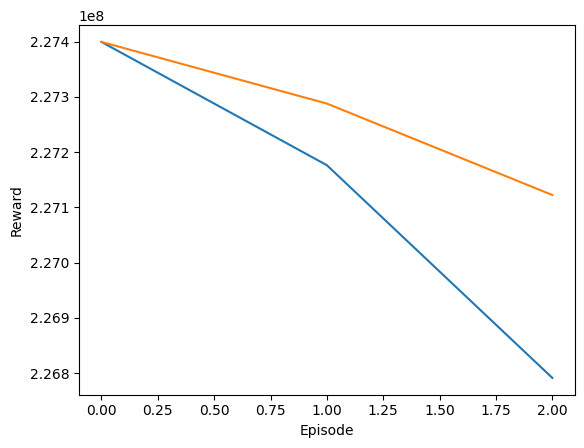

In [98]:
%matplotlib inline
plt.plot(Episode_rewards)
plt.plot(Avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show();

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the A2C model to trade Dow jones 30 stocks.

In [99]:
e_trade_gym = StockPortfolioEnv(df = trade, **trade_env_kwargs)
test_env, test_obs = e_trade_gym.get_sb_env()

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [100]:
account_memory, actions_memory, rewardd = agent.trade(env_trade, e_trade_gym, None)
print(rewardd)

<ipython-input-75-71c4acbcdf21>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = self.model(torch.tensor(state))


begin_total_asset:1000000
end_total_asset:855623.9204861495
Sharpe:  1.4979916534037514
hit end!
[5.443623e+08]


<ipython-input-75-71c4acbcdf21>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = self.model(torch.tensor(state))


In [101]:
calculate_sharpe(account_memory[0])

np.float64(1.4979916534037514)

In [102]:
from google.colab import files
account_memory[0].to_csv('df_daily_return_'+ Market +'_' + Reward +'.csv')
files.download('df_daily_return_'+ Market +'_' + Reward +'.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [103]:
actions_memory[0].head()

,ADANIENT.NS,ADANIPORTS.NS,APOLLOHOSP.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJAJFINSV.NS,BAJFINANCE.NS,BHARTIARTL.NS,BPCL.NS,...,SUNPHARMA.NS,TATACONSUM.NS,TATAMOTORS.NS,TATASTEEL.NS,TCS.NS,TECHM.NS,TITAN.NS,ULTRACEMCO.NS,UPL.NS,WIPRO.NS
date,,,,,,,,,,,,,,,,,,,,,
2023-01-02,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,...,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277
2023-01-03,0.027942,0.019556,0.040332,0.015633,0.013540,0.027734,0.006646,0.030137,0.030122,0.035457,...,0.010937,0.019816,0.035861,0.020911,0.015972,0.033528,0.032471,0.041315,0.019832,0.017355
2023-01-04,0.017314,0.033626,0.031453,0.009429,0.035540,0.043778,0.044588,0.016107,0.033822,0.009353,...,0.026250,0.020197,0.009360,0.017526,0.007506,0.021733,0.013161,0.041850,0.018139,0.011038
2023-01-05,0.020691,0.015218,0.016012,0.026006,0.019792,0.008878,0.011877,0.009386,0.016765,0.039757,...,0.026496,0.020429,0.011920,0.016678,0.032619,0.015358,0.026239,0.045228,0.009285,0.023362
2023-01-06,0.011017,0.027428,0.031240,0.011188,0.031926,0.015815,0.011757,0.008954,0.020922,0.039209,...,0.031889,0.023123,0.032809,0.017714,0.008403,0.029679,0.007363,0.016263,0.024166,0.011998


In [104]:
actions_memory[0].to_csv('df_actions_Trade_'+ Market +'_' + Reward +'.csv')
files.download('df_actions_Trade_'+ Market +'_' + Reward +'.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [105]:
df_daily_return = account_memory[0]

In [106]:
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)
test_env, test_obs = e_trade_gym.get_sb_env()

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [107]:
account_memory, actions_memory, rewardd = agent.trade(env_trade, e_trade_gym, None)
print(rewardd)

<ipython-input-75-71c4acbcdf21>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = self.model(torch.tensor(state))


begin_total_asset:1000000
end_total_asset:838029.5331062152
Sharpe:  1.4204514326658473
hit end!
[5.3320582e+08]


<ipython-input-75-71c4acbcdf21>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = self.model(torch.tensor(state))


In [108]:
df_daily_return_T = account_memory[0]

In [109]:
from google.colab import files
df_daily_return_T.to_csv('df_daily_return_WT '+ Market +'_' + Reward +'.csv')
files.download('df_daily_return_WT '+ Market +'_' + Reward +'.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class
# Nifty 50 -- ^NSEI
# Sensex 30 -- ^BSESN
# Dow 30 -- ^DJI
# DAX 40 -- ^GDAXI
# HSI 30 -- ^HSI
# TIRKEY -- XU100.IS
# Nikeei -- ^N225
# IBEX Spain -- ^IBEX
# Tiwan -- ^TWII
# Nifty 100 -- ^CNX100

In [110]:
%%capture
!pip install numpy==1.26.4

In [111]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return_T)
perf_func = perf_stats
perf_stats_all = perf_func( returns=DRL_strat,
                              factor_returns=DRL_strat,
                                positions=None, transactions=None, turnover_denom="AGB")

In [112]:
print("==============DRL Strategy Stats===========")
print(perf_stats_all)

==============DRL Strategy Stats===========
Annual return         0.186473
Cumulative returns    0.455306
Annual volatility     0.126010
Sharpe ratio          1.420451
Calmar ratio          1.111647
Stability             0.860776
Omega ratio           1.275278
dtype: float64


In [113]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker= BL,
        start = df_daily_return.loc[0,'date'],
        end = df_daily_return.loc[len(df_daily_return)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')
print(stats)

[*********************100%***********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (551, 8)
Annual return         0.126076
Cumulative returns    0.296443
Annual volatility     0.121766
Sharpe ratio          1.038129
Calmar ratio          0.799637
Stability             0.841576
Omega ratio           1.198687
dtype: float64
Annual return         0.126076
Cumulative returns    0.296443
Annual volatility     0.121766
Sharpe ratio          1.038129
Calmar ratio          0.799637
Stability             0.841576
Omega ratio           1.198687
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

In [114]:
pip install empyrical==0.3.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for empyrical: filename=empyrical-0.3.4-py3-none-any.whl size=27176 sha256=3e88a609765c0e716ccf5cb4fc15fdc55b175dd9beea9d4e2433ae833c83c6df
  Stored in directory: /root/.cache/pip/wheels/f9/21/2d/f91e36821130f7ff07050fb24b405ae55da0e781d4710665cd
Successfully built empyrical
  Attempting uninstall: empyrical
    Found existing installation: empyrical 0.5.5
    Uninstalling empyrical-0.5.5:
      Successfully uninstalled empyrical-0.5.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyfolio 0.9.2 requires empyrical>=0.5.0, but you have empyrical 0.3.4 which is incompatible.


In [115]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker=BL, start=df_daily_return.loc[0,'date'], end='2025-02-28')

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

# with pyfolio.plotting.plotting_context(font_scale=1.1):
#         pyfolio.create_full_tear_sheet(returns = DRL_strat,
#                                        benchmark_rets=baseline_returns, set_context=False)

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (532, 8)


In [116]:
DRL_strat

,0
date,
2023-01-02 00:00:00+00:00,0.000000
2023-01-03 00:00:00+00:00,0.000993
2023-01-04 00:00:00+00:00,-0.009479
2023-01-05 00:00:00+00:00,0.002292
2023-01-06 00:00:00+00:00,-0.008315
...,...
2025-03-24 00:00:00+00:00,0.010738
2025-03-25 00:00:00+00:00,-0.002032
2025-03-26 00:00:00+00:00,-0.005903


In [117]:
baseline_returns

,daily_return
date,
2023-01-02 00:00:00+00:00,NaN
2023-01-03 00:00:00+00:00,0.001929
2023-01-04 00:00:00+00:00,-0.010399
2023-01-05 00:00:00+00:00,-0.002815
2023-01-06 00:00:00+00:00,-0.007376
...,...
2025-02-20 00:00:00+00:00,-0.000861
2025-02-21 00:00:00+00:00,-0.005117
2025-02-24 00:00:00+00:00,-0.010640


In [118]:
baseline_returns.to_csv('Baseline_Daily_Return_'+ Market +'.csv')
files.download('Baseline_Daily_Return_'+ Market +'.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Min-Variance Portfolio Allocation

In [119]:
%pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 14.3 MB/s eta 0:00:00


In [120]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

In [121]:
unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()

In [122]:
#calculate_portfolio_minimum_variance
portfolio = pd.DataFrame(index = range(1), columns = unique_trade_date)
initial_capital = 1000000
portfolio.loc[0,unique_trade_date[0]] = initial_capital

for i in range(len( unique_trade_date)-1):
    df_temp = df[df.date==unique_trade_date[i]].reset_index(drop=True)
    df_temp_next = df[df.date==unique_trade_date[i+1]].reset_index(drop=True)
    #Sigma = risk_models.sample_cov(df_temp.return_list[0])
    #calculate covariance matrix
    Sigma = df_temp.return_list[0].cov()
    #portfolio allocation
    ef_min_var = EfficientFrontier(None, Sigma,weight_bounds=(0, 0.1))
    #minimum variance
    raw_weights_min_var = ef_min_var.min_volatility()
    #get weights
    cleaned_weights_min_var = ef_min_var.clean_weights()

    #current capital
    cap = portfolio.iloc[0, i]
    #current cash invested for each stock
    current_cash = [element * cap for element in list(cleaned_weights_min_var.values())]
    # current held shares
    current_shares = list(np.array(current_cash)
                                      / np.array(df_temp.close))
    # next time period price
    next_price = np.array(df_temp_next.close)
    ##next_price * current share to calculate next total account value
    portfolio.iloc[0, i+1] = np.dot(current_shares, next_price)

portfolio=portfolio.T
portfolio.columns = ['account_value']

/usr/local/lib/python3.11/dist-packages/osqp/interface.py:290: DeprecationWarning: "polish" is deprecated. Please use "polishing" instead.
  warnings.warn(


KeyboardInterrupt: 

# Markowitz's with Transection Cost

In [ ]:
#calculate_portfolio_minimum_variance
portfolio = pd.DataFrame(index = range(1), columns = unique_trade_date)
initial_capital = 1000000
portfolio.loc[0,unique_trade_date[0]] = initial_capital

# Define transaction cost rate
transaction_cost_rate = 0.005

for i in range(len( unique_trade_date)-1):
    df_temp = df[df.date==unique_trade_date[i]].reset_index(drop=True)
    df_temp_next = df[df.date==unique_trade_date[i+1]].reset_index(drop=True)
    #Sigma = risk_models.sample_cov(df_temp.return_list[0])
    #calculate covariance matrix
    Sigma = df_temp.return_list[0].cov()
    #portfolio allocation
    ef_min_var = EfficientFrontier(None, Sigma,weight_bounds=(0, 0.1))
    #minimum variance
    raw_weights_min_var = ef_min_var.min_volatility()
    #get weights
    cleaned_weights_min_var = ef_min_var.clean_weights()

    #current capital
    cap = portfolio.iloc[0, i]
    #current cash invested for each stock
    current_cash = [element * cap for element in list(cleaned_weights_min_var.values())]
    # current held shares
    current_shares = list(np.array(current_cash)
                                      / np.array(df_temp.close))
    # next time period price
    next_price = np.array(df_temp_next.close)

    # Calculate next portfolio value without transaction cost
    next_value = np.dot(current_shares, next_price)

    # Calculate transaction costs
    new_shares = current_cash / next_price
    share_differences = np.abs(new_shares - current_shares)
    transaction_cost = np.sum(share_differences * next_price * transaction_cost_rate)

    # Deduct transaction cost from portfolio value
    portfolio.iloc[0, i + 1] = next_value - transaction_cost

portfolio=portfolio.T
portfolio.columns = ['account_value']

In [ ]:
def calculate_daily_return(current_value, previous_value):
    return (current_value - previous_value) / previous_value

# Calculate daily return and add it as a new column
daily_returns = [0]  # Daily return for the first day is assumed to be 0
for i in range(1, len(portfolio)):
    current_value = portfolio['account_value'][i]
    previous_value = portfolio['account_value'][i - 1]
    daily_returns.append(calculate_daily_return(current_value, previous_value))

portfolio['daily_return'] = daily_returns

print(portfolio)

In [ ]:
portfolio.head()

In [ ]:
Agent =(df_daily_return_T.daily_return+1).cumprod()-1

In [ ]:
min_var_cumpod =(portfolio.account_value.pct_change()+1).cumprod()-1

In [ ]:
portfolio.drop(columns=['account_value'], inplace=True)
portfolio.to_csv('Markowitz_Portfolio_Return_'+ Market +'.csv')
files.download('Markowitz_Portfolio_Return_'+ Market +'.csv')

In [ ]:
Baseline =(baseline_returns+1).cumprod()-1

## Plotly: DRL, Min-Variance, DJIA

In [ ]:
%pip install plotly

In [ ]:
from datetime import datetime as dt

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

In [ ]:
time_ind = pd.Series(df_daily_return_T.date)

In [ ]:
trace0_portfolio = go.Scatter(x = time_ind, y = Agent, mode = 'lines', name = 'Agent (Portfolio Allocation)')

trace1_portfolio = go.Scatter(x = time_ind, y = Baseline, mode = 'lines', name = 'Baseline')
trace2_portfolio = go.Scatter(x = time_ind, y = min_var_cumpod, mode = 'lines', name = 'Min-Variance')
#trace3_portfolio = go.Scatter(x = time_ind, y = a2c_cumpod_esg, mode = 'lines', name = 'ESG-A2C (Portfolio Allocation)')
#trace3_portfolio = go.Scatter(x = time_ind, y = ddpg_cumpod, mode = 'lines', name = 'DDPG')
#trace4_portfolio = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')
#trace5_portfolio = go.Scatter(x = time_ind, y = min_cumpod, mode = 'lines', name = 'Min-Variance')

#trace4 = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')

#trace2 = go.Scatter(x = time_ind, y = portfolio_cost_minv, mode = 'lines', name = 'Min-Variance')
#trace3 = go.Scatter(x = time_ind, y = spx_value, mode = 'lines', name = 'SPX')

In [ ]:
fig = go.Figure()
fig.add_trace(trace0_portfolio)

fig.add_trace(trace1_portfolio)

fig.add_trace(trace2_portfolio)

#fig.add_trace(trace3_portfolio)

fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2

    ),
)
#fig.update_layout(legend_orientation="h")
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
#with Transaction cost
#fig.update_layout(title =  'Quarterly Trade Date')
fig.update_layout(
#    margin=dict(l=20, r=20, t=20, b=20),

    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    #xaxis_title="Date",
    yaxis_title="Cumulative Return",
xaxis={'type': 'date',
       'tick0': time_ind[0],
        'tickmode': 'linear',
       'dtick': 86400000.0 *80}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show()

fig.write_image("portfolio_return_plot.png")

# Download the file
files.download("portfolio_return_plot.png")
